# 1 Importing dependencies and Data

In [116]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Importing the data recorded from the pressure ports

In [117]:
pressures = pd.read_csv('raw_testG41.csv')
pressures.columns

Index(['  Run_nr', '    Time', '   Alpha', 'Delta_Pb', '   P_bar', '       T',
       '     rpm', '     rho', '    P001', '    P002',
       ...
       '    P104', '    P105', '    P106', '    P107', '    P108', '    P109',
       '    P110', '    P111', '    P112', '    P113'],
      dtype='object', length=121)

In [118]:
pressures.dtypes

  Run_nr    object
    Time    object
   Alpha    object
Delta_Pb    object
   P_bar    object
             ...  
    P109    object
    P110    object
    P111    object
    P112    object
    P113    object
Length: 121, dtype: object

Importing the coordinates of each static port on the airfoil

In [119]:
airfoil_ports = pd.read_csv('airfoil_coordinates.csv')
airfoil_ports.columns

Index(['Port Name', 'x', 'y'], dtype='object')

## Processing to floats

In [120]:
pressures = pressures.drop(labels=0)

In [121]:
pressures.columns = pressures.columns.str.strip(' ')
pressures.columns

Index(['Run_nr', 'Time', 'Alpha', 'Delta_Pb', 'P_bar', 'T', 'rpm', 'rho',
       'P001', 'P002',
       ...
       'P104', 'P105', 'P106', 'P107', 'P108', 'P109', 'P110', 'P111', 'P112',
       'P113'],
      dtype='object', length=121)

In [122]:
pressures = pressures.drop(labels= ['Time', 'Run_nr'], axis=1)

In [123]:
pressures = pressures.astype(float)

## Seslect a specific angle of attack

In [91]:
# here insert your angle of attack
aoa = 8

In [112]:
if aoa in pressures['Alpha'].values:
    current = pressures[pressures['Alpha'] == aoa]
else: 
    raise Exception('This angle of attack was not measured during the test or the number is inserted incorrectly')

current = current.copy()
current

,Alpha,Delta_Pb,P_bar,T,rpm,rho,P001,P002,P003,P004,...,P104,P105,P106,P107,P108,P109,P110,P111,P112,P113
16,8.0,138.89,1025.29,20.87,889.86,1.215,-785.33,-577.5,-577.44,-484.92,...,16.06,14.89,13.69,12.07,12.0,18.36,0.1,-0.01,-0.11,-0.08


## Transform the curve from pressure distribution to dimensionless coefficient $C_p \: [-]$

In [125]:
current['q_inf'] = 0.211804 + 1.928442*current['Delta_Pb'] + 1.879374 *10**(-4) * current['Delta_Pb']**2

current['q_inf']

16    271.678507
Name: q_inf, dtype: float64

In [114]:
current.loc[:, 'P001':'P049'] = (current.loc[:, 'P001':'P049']).add(current.loc[:, 'P_bar'] * 1e2, axis=0)
current

,Alpha,Delta_Pb,P_bar,T,rpm,rho,P001,P002,P003,P004,...,P105,P106,P107,P108,P109,P110,P111,P112,P113,q_inf
16,8.0,138.89,1025.29,20.87,889.86,1.215,101743.67,101951.5,101951.56,102044.08,...,14.89,13.69,12.07,12.0,18.36,0.1,-0.01,-0.11,-0.08,271.678507


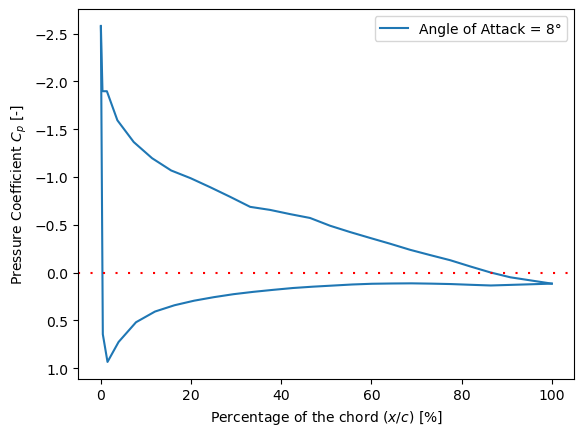

In [115]:
upper = cp_distributions.loc[:, 'P001':'P025'].to_numpy().flatten()
lower = cp_distributions.loc[:, 'P026':'P049'].to_numpy().flatten()

plt.plot(airfoil_ports['x'][0:25], upper, color= 'tab:blue', label=f'Angle of Attack = {aoa}°')
plt.plot(airfoil_ports['x'][25:49], lower, color= 'tab:blue')
plt.axhline(0.0, linestyle=(0, (1, 5)), color='red')
plt.xlabel('Percentage of the chord $(x/c)$ [%]')
plt.ylabel(r'Pressure Coefficient $C_p$ [-]')
plt.gca().invert_yaxis()

plt.legend()
plt.show()